In [1]:
import torch as th
import pandas as pd
import re
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
from NLPUtils.preprocessUtils import removeWord

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Iterable
from torch.utils.data import Dataset, DataLoader

class IMDBDatasetForTextClassifiation(Dataset):

    def __init__(self,file = None, removeWordFile = None, MAX_LEN = 30, train = True, train_voc = None) -> None:
        super(IMDBDatasetForTextClassifiation, self).__init__()
        self.UNKTOKEN = '<unk>'
        with open(removeWordFile, 'r', encoding='utf-8') as f:
                self.removeWordList = [removeWord.replace('\n', '') for removeWord in f.readlines()]
        self.maxlen = MAX_LEN
        if train:
            self.df = pd.read_csv(file, encoding='utf-8')[:40000]
            self.voc = set()
            self.voc.add(self.UNKTOKEN)
            print(f'Constructing Vocabulary...')
            for sentence in tqdm(self.df['review']):
                self.voc.update(self.removeWord(removeWordList=self.removeWordList, sentence=self.preprocess(sentence)))
            print(f'The Vocabulary size is {len(self.voc)}')
            print(f'Constructing Word2Index Table...')
            self.word2idx = {word : idx for idx, word in enumerate(self.voc)}
            self.idx2word = {idx : word for idx, word in enumerate(self.voc)}
            print('DONE!')
        else:
            self.df = pd.read_csv(file, encoding='utf-8')[40000:]
            self.voc = train_voc
            self.word2idx = {word : idx for idx, word in enumerate(self.voc)}
            self.idx2word = {idx : word for idx, word in enumerate(self.voc)}
        self.df.reset_index(inplace=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> th.Tensor:
        preprocessed_data = self.removeWord(removeWordList=self.removeWordList, sentence = self.preprocess(self.df['review'][index]))[:self.maxlen]
        while len(preprocessed_data) < self.maxlen:
            preprocessed_data.append(self.idx2word[self.word2idx[self.UNKTOKEN]])
        x_list = []
        for word in preprocessed_data:
            if word not in self.voc:
                x_list.append(self.word2idx[self.UNKTOKEN])
            else:
                x_list.append(self.word2idx[word])
        x = th.tensor(x_list, dtype=th.long)
        y = 0 if self.df['sentiment'][index] == 'positive' else 1
        return x, y

    def preprocess(self, sentence):
        return str.translate(sentence, str.maketrans('','', string.punctuation)).lower().split()[:self.maxlen]

    def removeWord(self, removeWordList: list, sentence : Iterable):
        for removeWord in removeWordList:
            sentence = list(filter(removeWord.__ne__,sentence))
        return sentence

In [3]:
csvFilePath = '../basic_dataset/IMDB/IMDB Dataset.csv'
stopWordFile = './NLPUtils/english.txt'
BATCH_SIZE = 128
MAX_LEN = 300
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'

In [4]:
print(f'Using {DEVICE}')

Using cuda


In [5]:
trainDataset = IMDBDatasetForTextClassifiation(csvFilePath, removeWordFile=stopWordFile, MAX_LEN=MAX_LEN, train=True)
trainDataloader = DataLoader(trainDataset, batch_size=BATCH_SIZE)

Constructing Vocabulary...


100%|██████████| 40000/40000 [02:09<00:00, 309.12it/s]

The Vocabulary size is 143255
Constructing Word2Index Table...
DONE!


In [6]:

from torch.nn import Module
class TextClassificationModel(Module):

    def __init__(self, voc_size) -> None:
        super(TextClassificationModel, self).__init__()
        self.embeddingLayer = th.nn.EmbeddingBag(voc_size, 200)
        self.linear1 = th.nn.Linear(200, 64)
        self.linear2 = th.nn.Linear(64, 2)
        self.initWeight()
    
    def initWeight(self):
        initrange = 1
        self.embeddingLayer.weight.data.uniform_(-initrange, initrange)
        self.linear1.weight.data.uniform_(-initrange, initrange)
        self.linear1.bias.data.zero_()
        self.linear2.weight.data.uniform_(-initrange, initrange)
        self.linear1.bias.data.zero_()

    
    def forward(self, x):
        x = self.embeddingLayer(x)
        x = th.nn.functional.relu(x)
        x = self.linear1(x)
        x = th.nn.functional.relu(x)
        x = self.linear2(x)
        return x


# 永遠記得PyTorch的CrossEntropy跟大家的都不一樣
Pytorch CrossEntropy = NLLloss + logSoftmax 所以你的標籤不能是one-hot<br>
必須是標籤對應的index 比如正向評論在理論上為[1.,0.]但必需表示成其index也就是0

In [7]:
model = TextClassificationModel(len(trainDataset.voc)).to(DEVICE)
loss_fn = th.nn.CrossEntropyLoss()
opti = th.optim.Adam(model.parameters(), lr=1e-3)

# 還有記得在訓練期間 梯度記得清零
會犯這個錯還蠻白癡的...找半天找不到BUG...

In [8]:
losses = []
for epoch in range(20):
    for x,y in tqdm(trainDataloader):
        opti.zero_grad()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
    losses.append(loss.item())
    


100%|██████████| 313/313 [02:16<00:00,  2.29it/s]


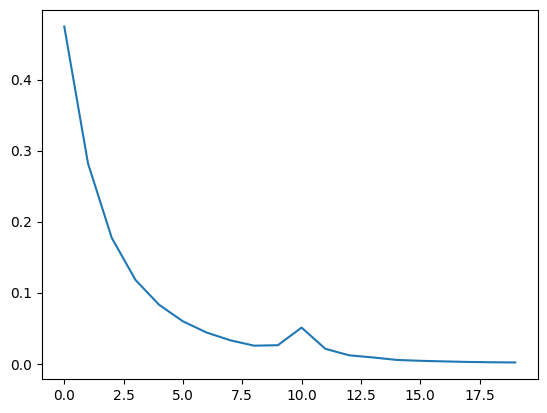

In [9]:
plt.plot(losses)
plt.show()

In [10]:
testDataset = IMDBDatasetForTextClassifiation(csvFilePath, removeWordFile=stopWordFile, train=False, MAX_LEN=MAX_LEN , train_voc=trainDataset.voc)
testDataloader = DataLoader(testDataset, batch_size=BATCH_SIZE)

In [11]:
with th.no_grad():
    correct = 0.
    for x,y in trainDataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(th.float32).sum()
    acc = correct/len(trainDataloader.dataset)
    print(f'Acc is {acc}')

Acc is 0.9990249872207642


In [12]:
print(f'Correct = {correct}')
print(f'Total {len(trainDataloader.dataset)}')

Correct = 39961.0
Total 40000


In [13]:
with th.no_grad():
    correct = 0.
    for x,y in testDataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(th.float32).sum()
    acc = correct/len(testDataloader.dataset)
    print(f'Acc is {acc}')

Acc is 0.8737999796867371


In [14]:
print(f'Correct = {correct}')
print(f'Total {len(testDataloader.dataset)}')

Correct = 8738.0
Total 10000
